# An Analysis of ADADelta and ADAM Optimizers

## Part I: The Need for Adaptive Optimization
Training deep neural networks is fundamentally an optimization problem: finding model parameters ($ \theta $) that minimize a cost function ($ J(\theta) $). However, the loss landscapes of these models presents significant challenges for simple optimization algorithms. Traditional methods like **Stochastic Gradient Descent (SGD)** struggle with several key issues that motivated the development of more advanced, adaptive techniques:

- **Difficult Navigation**: The presence of numerous local minima and, more commonly, saddle points can cause optimizers to slow down or get stuck, hindering convergence.
- **Gradient Scaling Issues**: In deep networks, gradients can shrink exponentially (vanish) or grow uncontrollably (explode), making stable training difficult.
- **Inflexible Learning Rate**: SGD uses a single, fixed learning rate for all parameters. This is inefficient, as a rate that is too small leads to slow convergence, while one that is too large can cause the loss to diverge. Manually tuning this hyperparameter is a difficult and time-consuming process.

So, To overcome the learning rate problems, the adaptive methods like **AdaDelta & ADAM** can help us, while **AdaDelta** provides the adaptive learning rates per parameter of **Adagrad**, but prevents the learning rate from decaying too aggressively, and **ADAM** provides a learning-rate-free method



## Part II: Pre-requisites 

### 2.1 AdaGrad 

AdaGrad stands for **Adaptive Gradient Algorithm**, it is an optimization algorithm that is designed to adapt the learning rate for each parameter. It is really useful for sparse features (a feature that appears much less frequently than other features). 

$$
\eta_i = \frac{\eta_0}{\sqrt{t} + c}
$$

Instead of considering the learning rate for every parameters as the same, as the above formula, Adagrad adapts by giving each parameter its own learning rate. To achieve this, AdaGrad maintains an accumulator $s(i,t)$ for each parameter, which is updated at every step by summing with the square of the current gradient 
$$
s(i, t+1) = s(i, t) + (\partial_i f(\mathbf{x}))^2
$$

This growing sum of past squared gradients is then used to scale the learning rate in the final parameter update rule
$$
w_{i,t+1} = w_{i,t} - \frac{\eta}{\sqrt{s(i, t) + \epsilon}} (\partial_i f(\mathbf{x}))
$$

As a result, parameters that have experienced large gradients in the past will have their learning rate reduced, while parameters with small gradients will maintain a higher learning rate, within this idea, making AdaGrad much more suitable for problems that have sparse features


#### 2.1.1 Implementation 

Using AdaGrad in different computer science problems, which require us to convert the mathematical theory into a clear and concrete language that machines can understand. I would like to provide a class AdaGrad in Python, which represents the AdaGrad algorithm, and for more details about the testing, can refer to this Github repository: https://github.com/hu1909/AdaDelta_and_ADAM/blob/main/implementation/AdaGrad-implementation.ipynb


In [ ]:
import numpy as np

class Adagrad:
    
    def __init__(self, learning_rate: float, constant: float):
        self.learning_rate = learning_rate
        self.constant = constant

        # s(i,t)
        self.accumulated_gradients = None

        
    def calculate_param(self, params: np.ndarray, gradients: np.ndarray):
        if self.accumulated_gradients is None:
            self.accumulated_gradients = np.zeros_like(params)
        
        # Accumulate squared gradients
        self.accumulated_gradients += gradients ** 2
        
        # Compute adaptive learning rate
        adaptive_lr = self.learning_rate / (np.sqrt(self.accumulated_gradients) + self.constant)
        
        # Update parameters
        updated_params = params - adaptive_lr * gradients
        
        return updated_params

#### 2.1.2 Limitation

The weakness of AdaGrad can be exposed within this formula 

$$
s(i, t+1) = s(i, t) + (\partial_i f(\mathbf{x}))^2
$$

Basically, right-hand side of the equation cannot be negative which indicate that the accumulator of historical gradient keeps growing over time and never decreases, so it can become exceedingly large over many iterations. Because of this, the learning rate can become so small that the model's parameters stop updating in any meaningful way, preventing it from converging to an optimal solution

Below is an simulation about the rapidly decrease of learning rate within AdaGrad 


Simulating Adagrad Limitations


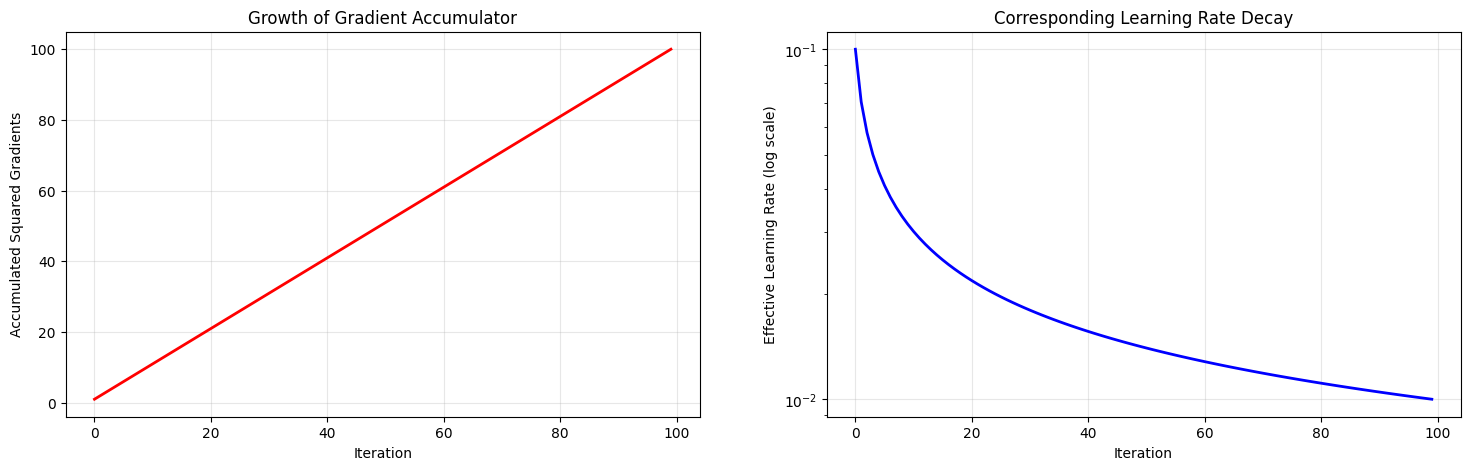

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def analyze_growth():
    gradient_magnitude = 1.0
    num_iterations = 100
    s = 0 # accumulator 
    s_list = [] # accumulator_history 
    lr_list = [] # effective_lr_history 
    initial_lr = 0.1
    eps = 1e-8
    
    for i in range(num_iterations):
        s += gradient_magnitude ** 2
        s_list.append(s)
        effective_lr = initial_lr / (np.sqrt(s) + eps)
        lr_list.append(effective_lr)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    
    ax1.plot(s_list, linewidth=2, color='red')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Accumulated Squared Gradients')
    ax1.set_title('Growth of Gradient Accumulator')
    ax1.grid(True, alpha=0.3)
    
    ax2.semilogy(lr_list, linewidth=2, color='blue')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Effective Learning Rate (log scale)')
    ax2.set_title('Corresponding Learning Rate Decay')
    ax2.grid(True, alpha=0.3)
    
    return s_list, lr_list


if __name__ == "__main__":
    
    print("Simulating Adagrad Limitations")
    print("=" * 50)
    accumulator_hist, lr_hist = analyze_growth()

    


### 2.2 EMA 

EMA stand for **Exponential Moving Average** which is a statistical method used to create a smoothed average of a sequence of data. It places more weight on the most recent data points, with the influence of older points decreasing exponentially over time. Within the optimizers such as Adam, AdaDelta, EMA is used to **stabilize training**. Instead of using the raw, often noisy gradient at a single step, these optimizers use an EMA to estimate the gradient's direction and magnitube, helping the optimizer to navigate the loss landscape **more smoothly** and avoid being thrown off by erratic

The EMA can be expressed in the form of a formula as follows 

$$
v_t = \beta \cdot v_{t-1} + (1 - \beta) \cdot x_t
$$

Where:
* $v_t$ is the new EMA at the current timestep $t$.
* $v_{t-1}$ is the EMA from the previous timestep $t-1$.
* $x_t$ is the new data point at the current timestep (e.g., the current gradient).
* $\beta$ (beta) is the **decay rate** or smoothing factor, a value between 0 and 1.

#### 2.2.1 Implementation

In [ ]:
class EMA:
    def __init__(self, alpha, window, bias_correction):

        if alpha is not None and window is not None:
            raise ValueError("Specify either alpha or window, not both")
        
        if alpha is not None:
            if not 0 < alpha <= 1:
                raise ValueError("Alpha must be between 0 and 1")
            self.alpha = alpha
        elif window is not None:
            if window <= 0:
                raise ValueError("Window must be positive")
            self.alpha = 2.0 / (window + 1)
        else:
            raise ValueError("Must specify either alpha or window")
        
        self.bias_correction = bias_correction
    
    
    def update(self, new_value):
        self.t += 1
        if self.ema_value is None:
            self.ema_value = new_value
        else:
            self.ema_value = self.alpha * new_value + (1 - self.alpha) * self.ema_value
        
        if self.bias_correction:
            bias_corrected_ema = self.ema_value / (1 - (1 - self.alpha) ** self.t)
            return bias_corrected_ema
        else:
            return self.ema_value
    
    def get_current_value(self):
        if self.ema_value is None:
            return None
        if self.bias_correction:
            return self.ema_value / (1 - (1 - self.alpha) ** self.t)
        else:
            return self.ema_value

## Part III: AdaDelta & ADAM

### 3.1 AdaDelta - AdaGrad's Improvement

AdaDelta is a more complex optimization algorithm developed to get rid of the primary weakness of AdaGrad. To remove the weakness of AdaGrad, AdaDelta uses 2 parameters to capture the history data.

Instead of summing all the past gradients like AdaGrad, AdaDelta utilize an EMA which was expressed above, to only considers a recent window of gradients, preventing the denominator from growing infinite.

1. **Average of Past Squared Gradient**: This measures the recent magnitude of the gradients 
$$
s_t = \rho s_{t-1} + (1 - \rho)g_t^2
$$

2. **Average of Past Squared Updates**: This tracks the average size of its recent parameter updates

$$
\Delta x_t = \rho \Delta x_{t-1} + (1 - \rho)g_t'^2
$$

Above formula about $\Delta x_t$, we have a rescaled gradient which use to improve an update. So within the $g_t$, there is an interesting point is that, unlike its pioneer AdaGrad, it gets rid of the traditional learning rate ($\eta$) by replacing it with a ratio of the 2 averages described above. So, The update step is calculated with a rescaled gradient, $g'_t$
$$
g'_t = \frac{\sqrt{\Delta x_{t-1} + \epsilon}}{\sqrt{s_t + \epsilon}} \odot g_t
$$


#### 3.1.1 Implementation 
Here is the implementation of AdaDelta, which maintains 2 state variables $s_t$ $\Delta x_t$. For fully implementation and testing, can refer to this Github repo: https://github.com/hu1909/AdaDelta_and_ADAM/blob/main/implementation/AdaDelta-implementation.ipynb

In [ ]:
import numpy as np
from EMA_class import EMA 

class AdaDelta:
    def __init__(self, rho=0.95, constant=1e-6):
        self.rho = rho
        self.constant = constant
        self.s = EMA(1 - self.rho, bias_correction=False) 
        self.delta_x = EMA(1 - self.rho, bias_correction=False) 
        
    def update(self, params, gradients):
        if self.s is None:
            self.s = np.zeros_like(params)
            self.delta_x = np.zeros_like(params)
        
    
        self.s = self.s.calculate(gradients**2)
        rescaled_gradient = (np.sqrt(self.delta_x + self.constant) / 
                           np.sqrt(self.s + self.constant)) * gradients
        

        new_params = params - rescaled_gradient
        
        
        param_update = rescaled_gradient 
        self.delta_x = self.delta_x.calculate(param_update**2) 
        
        return new_params

### 3.2.2 Limitation 

As for removing the rapidly descreasing of the learning rate, turn out the Adadelta's training can become very slow, especially after many training epoches. This can be seen easily when we provide the same function and let Adagrad and AdaDelta to optimize, we could see the loss parameter of AdaDelta reduce slower 

Here is a result that I try to implement with Adagrad and AdaDelta on the same function 

Function: 
$$
f(x,y) = (x - 2)^2 + (y - 3)^2
$$

Adagrad Implementation  


| Step | x     | y     | Loss   |
|:-----|:------|:------|:-------| 
| 0    | 0.000 | 0.000 | 13.000 |
| 1    | 0.800 | 0.800 |  6.280 |
| 2    | 1.212 | 1.273 |  3.604 |
| 3    | 1.468 | 1.610 |  2.216 |
| 4    | 1.637 | 1.867 |  1.416 |
| 5    | 1.751 | 2.069 |  0.928 |


AdaDelta Implementation 

| Step | x     | y     | Loss   |
|:-----|:------|:------|:-------|
| 0    | 0.000 | 0.000 | 13.000 |
| 1    | 0.001 | 0.001 | 12.990 |
| 2    | 0.002 | 0.002 | 12.976 |
| 3    | 0.004 | 0.004 | 12.962 |
| 4    | 0.005 | 0.005 | 12.947 |
| 5    | 0.007 | 0.007 | 12.933 |



### 3.2 ADAM - Adaptive Moment Estimation 

ADAM algorithm was developed by integrating several effective optimization technique into a single algorithm. Within the ADAM we can have some techniques such as 
1. **Mini-batching**: Using small batches for data, parallelized processing 
2. **Momentum**: Combine the history of the past gradients to help the optimizer move faster, and more consistently in the correct direction 
3. **Pre-coordinate Scaling**: Adjusting the learning rate for each parameter separately which kind of similar with AdaDelta and AdaGrad 

The core idea about the ADAM to combine these features together, it also use EMA to track the first moment (the momentum of the gradient) and the second moment (the uncentered variance of the gradient). These 2 moments was indicated within 2 state variables
1. **Momentum vector ($ v_t $)**: It tracks the direction of the updates 
$$
\mathbf{s}_t \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2)\mathbf{g}_t^2
$$
2. **Second moment vector ($ s_t $)**: It tracks the variance of the gradients and is used to scale the learning rate 
$$
\mathbf{v}_t \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1)\mathbf{g}_t
$$

Since the vector $v_0$ and $s_0$ are initialized to zero, which can make the intial estimates are biased towards 0. To fix this, Adam applies a bias correction which is the most significant during the early stages of training and become negligible as $t$ increase
$$
\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \quad \text{and} \quad \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}
$$

So within the corrected estimates, Adam compute the final update by first rescales the gradient by dividing the momentum estimate by the square root of the second moment estimate

$$
\mathbf{g}'_t = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}
$$

* $\eta$ is the learning rate.
* $\hat{\mathbf{v}}_t$ provides the direction of the update (the momentum).
* $\sqrt{\hat{\mathbf{s}}_t}$ **scales** the learning rate for each parameter individually. Parameters with higher variance will have smaller updates.
* $\epsilon$ is a small number (e.g., $10^{-6}$) added for **numerical stability** to prevent division by zero.


### 3.2.1 Implementation

A sample class which form by the mathematical formula above, for full implementation with some testing, please refer to this Github repo: https://github.com/hu1909/AdaDelta_and_ADAM/blob/main/implementation/Adam-implementation.ipynb

In [ ]:
import numpy as np
from EMA_class import EMA

class Adam:
    
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        # State variables
        self.v = EMA(1- self.beta1, bias_correction=True)  # First moment estimate (momentum)
        self.s = EMA(1 -self.beta2, bias_correction=True)  # Second moment estimate (variance)


    def momentum_vector(self, params, gradients):
        if isinstance(params, EMA):
            return params.calculate(gradients)
    

        
    def calculate(self, params, gradients):
        # Initialize state on first call
        v_hat = self.momentum_vector(self.v, gradients)
        s_hat = self.momentum_vector(self.s, gradients**2)
        rescaled_gradient = self.learning_rate * v_hat / (np.sqrt(s_hat) + self.epsilon)
        new_params = params - rescaled_gradient
        
        return new_params

### 3.2.2 Limitation and Improvement
Take a closer look on the second parameter
$$
\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) (\mathbf{g}_t^2 - \mathbf{s}_{t-1})
$$
The problem come from the term $(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$. If the new squared gradient $\mathbf{g}_t^2$ has very high variance or if the gradient updates are sparse, this difference can become very large. When this happens, $\mathbf{s}_t$ can change too rapidly, might miss its history of past gradient information quickly. This problem can prevent the model from converging properly


The Yogi come into picture which its core idea is control the magnitude of this update, so it will replace this term $(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$ with this one 

$$
\mathbf{g}_t^2 \odot \text{sgn}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})
$$

By doing this, the magnitude of the update no longer depends on how much $\mathbf{g}_t^2$ deviates, but only on its direction (the sign of the deviation). This prevents the explosive updates and leads to more stable training.

This result update the second moment like this 

$$
\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2)\mathbf{g}_t^2 \odot \text{sgn}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})
$$

In [ ]:
class Adam_Yogi:
    
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        # State variables
        self.v = None # First moment estimate (momentum)
        self.s = None  # Second moment estimate (variance)
        self.t = 0     # Time step counter

    

    def calculate(self, params, gradients):
        # Initialize state on first call
        if self.v is None:
            self.v = np.zeros_like(params)
            self.s = np.zeros_like(params)
        
        # Increment time step
        self.t += 1
        self.v = self.v = self.beta1 * self.v + (1 - self.beta1) * gradients
        self.s = self.s + (1 - self.beta2) * np.sign(gradients**2 - self.s) * gradients**2 # Yogi improvement
        v_hat = self.v / (1 - self.beta1**self.t)
        s_hat = self.s / (1 - self.beta2**self.t)
        rescaled_gradient = self.learning_rate * v_hat / (np.sqrt(s_hat) + self.epsilon)
        new_params = params - rescaled_gradient
        
        return new_params
    

For fully implementation, please refer to Github repo: https://github.com/hu1909/AdaDelta_and_ADAM/blob/main/implementation/Adam-implementation.ipynb

Within the improvement of Yogi for the second moment to be more robust to the spike of $ s_t $. We can clearly see in my fully implementation results 

**Adam Optimizer Results**

| Step | x | y | Loss | first-moment estimate  | second-moment estimate |
|:---|:----|:----|:-----|:----------------|:---------------------|
| 0 | 0.000 | 0.000 | 5.0000 | (-20.000,-40.000) | (4000.000,16000.000) |
| 5 | 0.088 | 0.089 | 4.4834 | (-2.809,-5.723) | (365.118,1461.139) |
| 10 | 0.161 | 0.164 | 4.0745 | (-2.026,-4.269) | (191.763,768.254) |
| 15 | 0.236 | 0.244 | 3.6675 | (-1.731,-3.801) | (130.092,522.030) |
| 20 | 0.312 | 0.330 | 3.2604 | (-1.538,-3.544) | (98.391,395.633) |

Within this table, we can clearly see that the initial large gradients explode *(4000.000, 16000.000)*, so this massive second-moment drastically reduces the effective learning rate. Therefore, we can see the Loss value decrease very slowly, only from **5.0 to 3.2604** in 20 steps


**Adam with Yogi Optimizer Results**

| Step | x | y | Loss | first-moment estimate  | second-moment estimate |
|:---|:----|:----|:-----|:--------------|:----------------|
| 0 | 0.000 | 0.000 | 5.0000 | ( init, init) | ( init, init) |
| 5 | 0.492 | 0.497 | 2.5180 | (-1.561,-3.559) | ( 2.652,13.073) |
| 10 | 0.923 | 0.974 | 1.0583 | (-0.968,-2.943) | ( 1.576,10.037) |
| 20 | 1.270 | 1.773 | 0.1245 | ( 0.015,-1.612) | ( 0.862, 5.990) |

In the other hand, within the Yogi, we could see the gradient is much smaller at *(2.652, 13.073)*. Because of the second-moment is kept in check, the optimizer can take larger which make the result in a much faster decrease in Loss, dropping from **5.0 to 0.1245** in the same 20 steps 

## Part IV: Application and User Cases

Both optimizers have been successfully applied to a variety of computer science problems, including Natural Language Processing (NLP) and Computer Vision (CV). Their strengths make them suitable for different scenarios depending on task complexity, data sparsity, and training dynamics.

- **ADADelta** is used in tasks where gradients are sparse or unstable, such as speech recognition systems  and early sequence modeling problems. It was commonly adopted in frameworks like Theano and Keras for models trained on handwriting recognition.

- **ADAM** is the default optimizer for many state-of-the-art models, including BERT and GPT for NLP, StyleGAN and YOLO for computer vision, and Proximal Policy Optimization (PPO) in reinforcement learning. It performs especially well in large-scale datasets like ImageNet and Wikipedia corpora.

In educational and research contexts, both optimizers are implemented from scratch to teach adaptive optimization. ADADelta helps illustrate unit-corrected updates, while ADAM demonstrates how momentum and scaling improve convergence in real-world models. 

## Part V: Conclusion

**ADADelta** and **ADAM** represent vital changes in the evolution of optimization algorithms. Both build upon the limitations of earlier methods like Adagrad by introducing exponential moving averages, but they differ in philosophy and practical impact. **ADADelta** simplifies training by leveraging the need of adaptive learning rate, making it useful in environments with limited tuning capability or sparse gradients. However, its convergence can be slower and less stable in complex scenarios.

ADAM, on the other hand, combines the strengths of momentum and adaptive learning rates with bias correction, making it one of the most robust and widely adopted optimizers today.

In practice, **ADAM is the recommended default optimizer** for most deep learning tasks due to its reliability and speed, while **ADADelta remains a valuable option** for specific cases where minimal hyperparameter tuning or sparse gradient updates are critical. A solid understanding of both helps practitioners choose the right tool based on task requirements and training behavior.

## Part VI: Practical with ADADelta & ADAM

### AdaDelta Practical 

#### 1. Adjust the value of ρ. What happens?

**Reasoning:** ρ controls the memory in the exponential moving average (EMA). Small ρ (e.g., 0.8) reacts quickly but causes instability; large ρ (e.g., 0.99) smooths updates but may slow convergence.

**Implementation Insight:** Values between 0.9 and 0.95 typically offer a good balance.

#### 2. Implement ADADelta without g'_t
**Reasoning:** We can directly compute the parameter update \( $\Delta x_t $\) and use it in both parameter and state updates.

**Benefit:** Reduces intermediate variables and clarifies logic.

In [10]:
def adadelta_no_g_prime(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            rms_g = torch.sqrt(s + eps)
            rms_delta_x_prev = torch.sqrt(delta + eps)
            delta_x = - (rms_delta_x_prev / rms_g) * p.grad
            p[:] += delta_x
            delta[:] = rho * delta + (1 - rho) * delta_x * delta_x
        p.grad.data.zero_()

#### 3. Is ADADelta really learning-rate free?
While ADADelta eliminates explicit η, the step size depends on ρ and state variables. In ill-conditioned problems with tiny gradients, training may stall. Many frameworks include a learning rate to address this.

#### 4. Compare ADADelta, Adagrad, and RMSProp
- **Adagrad**: Learning rate decays over time and can halt learning.
- **RMSProp**: Fixes Adagrad with EMA of gradients but still needs η.
- **ADADelta**: Adds EMA of updates to remove η.
- **Convergence**: ADADelta and RMSProp outperform Adagrad in long tasks; ADAM often converges even faster.

### ADAM Practical 

#### 1. Adjust learning rate η and analyze
ADAM's η controls update magnitude. Very small η slows learning; very large η may diverge. A value near 0.001 is usually optimal.

#### 2. Bias correction alternative
Bias correction compensates for moment initialization at 0. Alternatives (e.g., initializing with first gradient) exist but are less principled. The paper’s method is simple, effective, and parameter-free.


#### 3. Why reduce learning rate during convergence?
As convergence nears, gradient noise dominates. Reducing η helps prevent oscillation and enables fine-grained convergence — this is known as learning rate scheduling.


#### 4. When Adam diverges but Yogi converges
High-variance gradients can cause ADAM’s second-moment estimate to explode. Yogi controls this using the sign of the difference.

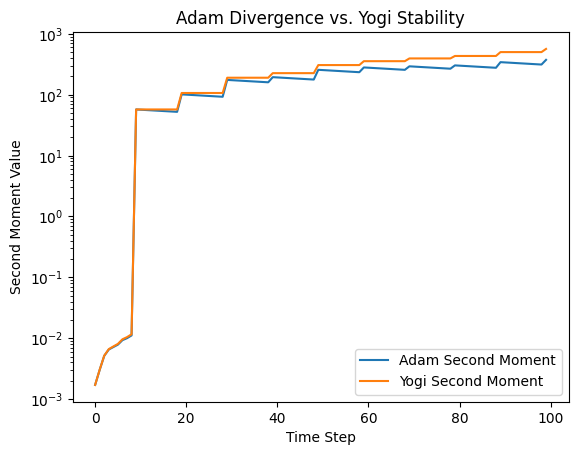

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def synthetic_gradient_generator(t):
    if t % 10 == 0:
        return np.random.uniform(50, 100)
    else:
        return np.random.uniform(0.1, 0.5)

beta2, num_steps = 0.99, 100
s_adam, s_yogi = 0, 0
adam_history, yogi_history = [], []

for t in range(1, num_steps + 1):
    grad = synthetic_gradient_generator(t)
    s_adam = s_adam + (1 - beta2) * (grad**2 - s_adam)
    s_yogi = s_yogi + (1 - beta2) * np.sign(grad**2 - s_yogi) * grad**2
    adam_history.append(s_adam)
    yogi_history.append(s_yogi)

plt.plot(adam_history, label='Adam Second Moment')
plt.plot(yogi_history, label='Yogi Second Moment')
plt.xlabel('Time Step'); plt.ylabel('Second Moment Value')
plt.title('Adam Divergence vs. Yogi Stability')
plt.legend(); plt.yscale('log'); plt.show()

## Part VII: References

- Duchi, J., Hazan, E., & Singer, Y. (2011). Adaptive subgradient methods for online learning and stochastic optimization. *JMLR*.
- Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization. *arXiv*.
- Reddi, S. J., Kale, S., & Kumar, S. (2019). On the Convergence of Adam and Beyond. *ICLR*.
- Ruder, S. (2016). An overview of gradient descent optimization algorithms. *arXiv*.
- Zeiler, M. D. (2012). ADADELTA: An Adaptive Learning Rate Method. *arXiv*.
- Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2024). *Dive into Deep Learning*. [https://d2l.ai](https://d2l.ai)